In [1]:
!pip install jupyter_beeper 
!pip install livelossplot
!pip install neurokit
!pip install 'nolds ==0.4'

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import h5py # Read and write HDF5 files from Python
import tensorflow as tf
from scipy.signal import welch, stft
import matplotlib.pyplot as plt
import matplotlib
import time
from livelossplot import PlotLossesKeras
import jupyter_beeper

from mne.decoding import SPoC

from sklearn.metrics import confusion_matrix
import pywt
#import nolds



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dreem-2-sleep-classification-challenge-2020/sample_submission.csv
/kaggle/input/dreem-2-sleep-classification-challenge-2020/y_train.csv
/kaggle/input/dreem-2-sleep-classification-challenge-2020/X_train.h5/X_train.h5
/kaggle/input/dreem-2-sleep-classification-challenge-2020/X_test.h5/X_test.h5


In [3]:
# filenames
data_path = "/kaggle/input/dreem-2-sleep-classification-challenge-2020/"
file_xtrain = data_path + "X_train.h5/X_train.h5"
file_xtest = data_path + "X_test.h5/X_test.h5"
file_ytrain = data_path + "y_train.csv"


In [4]:
def make_beep():
    b = jupyter_beeper.Beeper()

    b.beep(frequency=466, secs=0.5, blocking=True)
    time.sleep(0.1)
    b.beep(frequency=349, secs=0.5, blocking=True)
    time.sleep(0.1)
    b.beep(frequency=261, secs=0.5, blocking=True)
    time.sleep(0.1)
    b.beep(frequency=392, secs=0.5, blocking=True)
    
    return True

In [5]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jul 21 15:08:54 2020

@author: dtrocell
"""

#from raw_gdf import raw_gdf
import matplotlib.pyplot as plt
import mne

import pandas as pd
import numpy as np
import neurokit as nk
import biosppy 
import scipy.stats as stats
import pywt
import time as t  



''' ######### OPTIONAL : STOP BOTH MNE PRINTING AND PYTHON WARNINGS ############ '''
import warnings
warnings.filterwarnings("ignore")
mne.set_log_level("CRITICAL")



class Biosignal:
    
    
    
    def __init__(self, data, time):
        """ Put in memory the biosignal data and call the corresponding preprocessing function"""
        self.data = np.array(data)
        self.time = np.array(time)
        self.dt = time[1]-time[0]
        print(self.dt)
        self.features =  {}
        self.preprocessing()
        
    
    def crossing_detection(self, value=0):
        """ take a signal and a value return each time the signal cross the value """
        bool_pic= np.where(self.data >= value , True, False)
    
        crossings = np.where(np.diff(bool_pic))[0]

        return (crossings)
    
    def max_detection(self, crossings,value=0):
        """ Take the index where the raw cross a value and return the max between the two crossings """
        
               
        # fait qu'il y ai le bon nombre de pics.
        if self.data[0] > value:
            if self.data[1] <  self.data[0]: # si c'est décroissant
                crossings = crossings[1:]
            else :                  # si croisant 
                crossings= np.insert(crossings,0,0)
        
        if self.data[-1] > value: 
            if self.data[-2] < self.data [-1]: # si croissant
                crossings = crossings[:-1]
            else :                  #si décroissant
                crossings= np.append(crossings, len(self.data))
                
        assert(len(crossings)%2==0)
        
                    
        bins= np.zeros((len(crossings)//2,4))
        for i in range(len(crossings)//2) :
            begin = crossings[i*2]
            end = crossings[(i*2)+1]
            
            val_max = np.max(self.data[begin:end])
            arg_max = np.argmax(self.data[begin:end])+begin
            
            bins[i] = [begin, end, val_max, arg_max]
        
        return bins
    
    
    def  min_detection(self, crossings=None , value=0):
        """ Take the index where the raw cross a value and return the min between the two crossings """
        
        # fait qu'il y ai le bon nombre de pics.
        if self.data[0] < value:
            if self.data[1] <  self.data[0]: # si c'est décroissant
                crossings = np.insert(crossings,0,0) 
            else :                  # si croisant 
                crossings= crossings[1:]
        
        if self.data[-1] < value: 
            if self.data[-2] < self.data [-1]: # si croissant
                crossings = np.append(crossings, len(self.data)) 
            else :                  #si décroissant
                crossings= crossings[:-1]
                
        assert(len(crossings)%2==0)
        
        bins= np.zeros((len(crossings)//2,4))
        for i in range(len(crossings)//2) :
            begin = crossings[i*2]
            end = crossings[(i*2)+1]
            
            val_min = np.min(self.data[begin:end])
            arg_min= np.argmin(self.data[begin:end])+begin
            
            bins[i] = [begin, end, val_min, arg_min]
        
        return bins
    
    
    def freq_to_features(self,  power,freq):
        """Take the power spectral density and the corresponding frequencies and save them into the features dictionnary """
        
        
        for i in range(len(freq)):
            self.features["psd_"+str(freq[i])[:6]] = power[i]
    
    def bandpassfilter(self,lowpass=None,highpass=None):
        """ Use mne fonction to bandpass the data"""
        
        return (mne.filter.filter_data(self.data, 1/self.dt, lowpass, highpass ))
    
    def descriptive_statistics(self, name, array= None, stat_etendu= False):
        """ import a 1D numpy array and save the descriptive statistics (median , 
        standar deciation , count , minimim, maximum, 1st and 3rd quartile) in the features dictionnari """
        
        if  type(array) == type(None):
            array =self.data

        stat ={}
        
        stat[name+"_std"]= array.std()
        stat[name+"_count"]= len(array)
        stat[name+"_min"]= array.min()
        stat[name+"_max"]= array.max()
        stat[name+"_1quartile"],stat[name+"_median"],stat[name+"_3quartile"]= np.percentile(array,[0.25,0.5,0.75])
        stat[name+"_mean"]= array.mean()        
        if stat_etendu: 
            stat[name+"_skewness"]= stats.skew(array, axis=None, bias=True, nan_policy='raise')
            stat[name+"_kurtosis"]= stats.kurtosis(array, axis=None, fisher=True, bias=True, nan_policy='raise') 
        return stat
        
 
           
class Hr(Biosignal): 
    """Class that preprocess and extract features for respiration data"""


    def preprocessing(self): 
        """ Clean the data with a FIR and remove all frequencies above 40 Hz"""
        
        self.data, _,_  = biosppy.signals.tools.filter_signal(signal=self.data,ftype='FIR', band='lowpass', order=  int(0.3 * 1/self.dt) , frequency=[1], sampling_rate = 1/self.dt )
   
    
    def get_r_peaks(self,tolerance = 0.05,do_plot=False):
        """ algoritms develloped by dan, identify the peaks"""
        
        sampling_rate =1/self.dt
    
        # Todo modify, signal must have pair index for pywt
        self.data=self.data[1:]
        #Wavelet de reference,ressemble onde qrs
        db1=pywt.Wavelet('sym4')
        # Decomposition en ondelette
    
        coeffs=pywt.wavedec(self.data,db1,level=5)
        coeffs[0]=np.zeros(np.shape(coeffs[0]))
        coeffs[3]=np.zeros(np.shape(coeffs[3]))
        coeffs[4]=np.zeros(np.shape(coeffs[4]))
        coeffs[5]=np.zeros(np.shape(coeffs[5]))
        #Reconstruction
        reconstruction=pywt.waverec(coeffs,'sym4')
        reconstruction = np.abs(reconstruction)*np.abs(reconstruction);
    
        #Recherche des points inflections
        aux=np.diff(np.sign(np.diff(reconstruction)))
        zeross=np.squeeze(np.argwhere(aux<0))
       
        # Mask => On ne cherche que le max des ondes R (signal>0)
        mask=np.squeeze(self.data[zeross]>0)
        zeross=zeross[mask]
       
        # On ne veut pas detecter d'autres "petites" ondes T ...
        mask=np.array((reconstruction[zeross]>(np.max(reconstruction)/10)))
        zeross=zeross[mask]
       
        # On a besoin de récupérer avec précision le maximum,on
        # fait donc une recherche autour du point déterminé avec une tolérance
        tolerance = int(tolerance * sampling_rate)
        length = len(self.data)
        newR = []
        for r in zeross:
            a = r - tolerance
            if a < 0:
                continue
            b = r + tolerance
            if b > length:
                break
            newR.append(a + np.argmax(self.data[a:b])+1)
        if do_plot:
            plt.plot(self.data)
            plt.plot(newR,self.data[newR],'or')
        # Renvoie les index
        # To do: renvoyer amplitudes aussi?
        newR=np.array(newR)
        newR=np.unique(newR)
        self.peak = newR
        return (newR)
    
    
    def hearth_rate_variability(self):
        
        
        try :
            self.peak
        except :
            #self.get_r_peaks(tolerance=0.5,do_plot=False)
            cross = self.crossing_detection()
            self.peak =  self.max_detection(cross)[:,3].astype(int)
            
            plt.plot(self.data)
            
            plt.plot(self.peak,self.data[self.peak.astype(int)],'or')
            
         
            
        # 
        self.features.update( nk.ecg_hrv(self.peak, sampling_rate= 1/self.dt))
        
        #if you want the list and the explanation of nk.ecg_hrv dict try help()
        
        nn_interval = np.diff(self.peak) * self.dt
              

        #point carré geometrie 
        
        
        pc_rr1 = abs(nn_interval[:-1] - nn_interval[1:])
        
        pc_rr2= abs(-nn_interval[:-1] + 2*pc_rr1.mean() - nn_interval[1:] )
        #Je pense que cette formule est fausse
        
        

        self.features['sd_rr1'] = pc_rr1.std()
        self.features['sd_rr2'] = pc_rr2.std()
        print("Hr :"+str(len(self.features)))

        


        


    
#plt.plot( np.arange(len(test_set)),test_set)





In [6]:
%%capture


""" Load project data
    DataLoader and Dataset for single-channel EEG

"""
import tensorflow as tf
from scipy.interpolate import interp1d

def normalize_data(eeg_array):
    """normalize signal between 0 and 1"""

    normalized_array = np.clip(eeg_array, -150, 150)
    normalized_array = normalized_array / 150

    return normalized_array

    #----------------------------------------------------------------------------------------------------

def stft_preprocessing(data, mean= None, var=None):
    """Transform the signal in input in his STFT version, add a dimension"""
    
    shapedata = data.shape
    
    newdata = np.zeros((shapedata[0],129,13,shapedata[-1]))
    
    for i in range(shapedata[-1]):
        _, _, Zxx  = stft(data[:,:,i] ,fs = 50, axis= 1)
        
        Zxx = np.log(Zxx)
        cliped = np.clip(Zxx,-20,20)
        newdata[:,:,:,i] = cliped
    
    
    
    if mean ==None: 
        mean = newdata.mean() 
        

    newdata = newdata-mean
  
    if var==None :
        var = newdata.var()
    
    newdata = newdata/var

        
    
    return (newdata, mean,var)

def SPoC_preprocessing(x_train, y_train, x_validation, n_components= 6):

    x_train = np.moveaxis(x_train,1,-1)
    spoc_train= SPoC(n_components=n_components, reg='oas', rank='full', transform_into='csp_space')
    spoc_train.fit(x_train,y_train)

    x_train_copy = spoc_train.transform(x_train)
    x_train_copy = np.moveaxis(x_train_copy,1,-1)

    x_validation_copy = np.moveaxis(x_validation,1,-1)
    x_validation_copy = spoc_train.transform(x_validation_copy)
    x_validation_copy = np.moveaxis(x_validation_copy,1,-1)
    
    return (x_train_copy,x_validation_copy, spoc_train)
 
    #----------------------------------------------------------------------------------------------------
    
def save_submission(x_test) :
    results_classification= model.predict_classes(x_test)
    
    index = np.arange(24688,24688+24980)
    result = np.stack((index, results_classification), axis=-1)
    data = pd.dataset(result)
    data.to_csv('./sampleSubmission.csv')
    
    #np.savetxt('./sampleSubmission.csv' , result , delimiter=",")
    
    return True


    #----------------------------------------------------------------------------------------------------

def extract_testset(input_signals_list,  mean,var, spoc):
    with h5py.File(file_xtest, "r") as fi:
        if len(input_signals_list) == 1:
            x_data = fi[input_signals_list[0]][()]
        else:
            x_data = np.zeros([24980,1500,len(input_signals_list)])        
            for i in range(0, len(input_signals_list)):
                if 'x' in input_signals_list[i] or 'y' in input_signals_list[i] or 'z' in input_signals_list[i]:
                    f1 = interp1d(np.arange(0, 300), fi[input_signals_list[i]][()], axis=0)
                    xnew = np.linspace(0, 30, num=1500)
                    x_data[0:24980, 0:1500, i] = f1(xnew)
                else:
                    x_data[0:24980, 0:1500, i] = fi[input_signals_list[i]][()]
            
        
        x_data = np.moveaxis(x_data,1,-1)
        x_data = spoc.transform(x_data)
        x_data = np.moveaxis(x_data,1,-1)

        
        x_data,_,_ = stft_preprocessing(x_data,mean, var)
        

        
        
        return x_data

    
        #----------------------------------------------------------------------------------------------------

def coordinate_preprocessing(data, mean = None , var = None):
    
    
    if mean is None: 
        mean =  data.mean(axis=(0,1))
    else :
        data = data-mean
  
    if var is None :
        var = data.var(axis= (0,1))

    else :
        data = data/var
    
    
    data = np.diff(data, axis = 1)
    return (data , mean , var)
    

def positional_embeding(data): 
    
    data = np.array(data)
    
    pos = np.zeros([data.shape[0],6])
    
    pos[:,0]= data/1200
    
    
    angle =  [30, 60, 90, 120, 150] 
    for i in range(5):
        pos[:,i+1]=np.cos((data * np.pi)/angle[i]) 
    
    
    
    
    return pos 
        
def split_data(input_signals_list,validation_ratio=0.2):
    with h5py.File(file_xtrain, "r") as fi:
        if len(input_signals_list) == 1:
            x_data = fi[input_signals_list[0]][()]
        else:
            x_data = np.zeros([24980,1500,len(input_signals_list)])
            for i in range(0, len(input_signals_list)):
                if 'x' in input_signals_list[i] or 'y' in input_signals_list[i] or 'z' in input_signals_list[i] or "pulse" in input_signals_list[i] :
                    f1 = interp1d(np.arange(0, 300), fi[input_signals_list[i]][()], axis=1)
                    xnew = np.linspace(0, 299, num=1500)
                    x_data[0:24688, 0:1500, i] = f1(xnew)
                else:
                    x_data[0:24688, 0:1500, i] = fi[input_signals_list[i]][()]
        metadata =  fi["index_window"][()]
        
        y_data = pd.read_csv(file_ytrain)['sleep_stage'].to_numpy()
        # Creating data indices for training and validation splits:
        dataset_size = len(y_data)
        indices = list(range(dataset_size))
        split = int((1 - validation_ratio) * dataset_size)
        np.random.shuffle(indices)
        train_indices, val_indices = indices[:split], indices[split:]

        x_train, x_validation = x_data[train_indices], x_data[val_indices]
        meta_train, meta_validation = metadata[train_indices], metadata[val_indices]
        y_train, y_validation = y_data[train_indices], y_data[val_indices]
        
        
        
        
        mask_eeg = [0,1,2,3,4,5,6]
        
        x_train_spoc, x_validation_spoc, spoc = SPoC_preprocessing(x_train[:,:,mask_eeg], y_train, x_validation[:,:,mask_eeg], 4)
        
        
        x_train_eeg ,mean_eeg, var_eeg = stft_preprocessing(x_train_spoc)
        x_validation_eeg, _ , _ = stft_preprocessing(x_validation_spoc, mean_eeg,var_eeg)
        
        # X Y Z
        
        if 'x' in input_signals_list :
            mask_mvt= np.argwhere(np.logical_or(np.logical_or(input_signals_list == "x", input_signals_list == "y" ) , input_signals_list == "z" ))
            x_train_mvt, mean_mvt , var_mvt = coordinate_preprocessing(x_train[:,:,mask_mvt])
            x_validation_mvt, _ , _ = coordinate_preprocessing(x_validation[:,:,mask_mvt], mean_mvt, var_mvt)
            
            x_train_mvt = np.squeeze(x_train_mvt)
            x_validation_mvt = np.squeeze(x_validation_mvt)

        
        # index
        
        meta_train = positional_embeding(meta_train)
        print(meta_train)
        meta_validation = positional_embeding(meta_validation)
        

        
        #x_train, x_validation = normalize_data(x_train), normalize_data(x_validation)

    return x_train_mvt, x_train_eeg ,meta_train , y_train, x_validation_mvt, x_validation_eeg, meta_validation , y_validation , mean_mvt , var_mvt,mean_eeg, var_eeg, spoc

input_signals_list = np.array(['eeg_1','eeg_2','eeg_3','eeg_4','eeg_5', 'eeg_6', 'eeg_7',"x", "y","z"])
#input_signals_list = ['eeg_1','eeg_5']
#input_signals_list = ['eeg_1', 'eeg_2', 'eeg_4', 'eeg_5', 'eeg_6', 'eeg_7','y','x']
#input_signals_list = np.array(["x", "y","z"])

x_train_mvt, x_train_eeg ,meta_train , y_train, x_validation_mvt, x_validation_eeg, meta_validation , y_validation , mean_mvt , var_mvt,mean_eeg, var_eeg, spoc = split_data(input_signals_list, validation_ratio=0.3)


# load dataloaders - final_val is the dataset for the last validation
#train_dataset, final_val_dataset = get_train_validation_dataset('eeg_5')




[[ 6.25000000e-02  3.06161700e-16 -7.07106781e-01 -8.66025404e-01
  -3.82683432e-01  6.12323400e-17]
 [ 2.81666667e-01 -6.69130606e-01  4.06736643e-01  7.19339800e-01
  -8.38670568e-01  6.99663341e-01]
 [ 5.74166667e-01 -9.94521895e-01 -5.23359562e-02  4.69471563e-01
   6.88354576e-01 -2.89031797e-01]
 ...
 [ 2.20000000e-01 -8.09016994e-01  3.09016994e-01 -9.78147601e-01
   8.09016994e-01  7.28968627e-01]
 [ 7.12500000e-01 -5.39154082e-15  7.07106781e-01  6.12942380e-16
  -9.23879533e-01  5.87785252e-01]
 [ 3.28333333e-01 -9.13545458e-01 -2.07911691e-01  3.74606593e-01
  -6.29320391e-01 -3.87515586e-01]]


In [7]:
print(x_train_mvt.shape)
make_beep()

(17281, 1499, 3)


True

In [8]:

input_signals_list =  np.array(['eeg_1','eeg_2','eeg_3','eeg_4','eeg_5', 'eeg_6', 'eeg_7',"x", "y","z"])
#input_signals_list = ['eeg_1','eeg_5']
#input_signals_list = ['eeg_1', 'eeg_2', 'eeg_4', 'eeg_5', 'eeg_6', 'eeg_7','y','x']
#input_signals_list = np.array(["x", "y","z"])

mask= np.argwhere(np.logical_or(np.logical_or(input_signals_list == "x", input_signals_list == "y" ) , input_signals_list == "z" ))




In [9]:
input_signals_list[mask]


array([['x'],
       ['y'],
       ['z']], dtype='<U5')

In [10]:


def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def plot_heatmap(y_true,y_pred): 
    
    mat = confusion_matrix(y_true,y_pred)
    mat = mat/np.sum(mat ,axis =0)*100
    mat = mat.astype(np.int)

    fig, ax = plt.subplots()

    im, cbar = heatmap(mat, ['Wake','NREM1','NREM2','NREM3','REM'],['Wake','NREM1','NREM2','NREM3','REM'], ax=ax,
                       cmap="YlGn", cbarlabel="Pourcentage de classification")
    texts = annotate_heatmap(im, valfmt="{x:} %")

    fig.tight_layout()
    plt.show()
    


# Here start the changes

In [11]:


def custom_loss(ytrue, ypred):
    
    print(ypred)
    
    scce = tf.keras.losses.SparseCategoricalCrossentropy()
    
    weight =tf.constant([[0.85347313, 0.93098802, 0.6152054,  0.79114608, 0.80918737]])
    #weight =tf.constant([[0.00001, 1.0000, 0.00001, 0.00001, 0.001]])
    weight = tf.constant([[1.94355903, 2.70683738, 0.96141876, 1.55233263, 1.62986756]])
 
    y_hot = tf.one_hot(ytrue, 5)
    

    
    new_y = tf.expand_dims(ypred, axis=1)


    new_weight = tf.matmul(weight,new_y, transpose_b = True)
    
    score = scce(ytrue,ypred, sample_weight= new_weight)
    
    return score



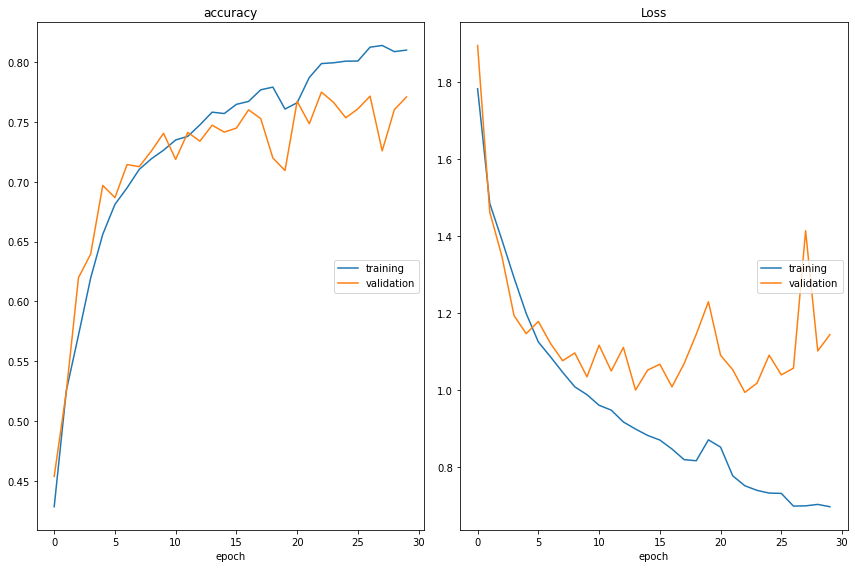

accuracy
	training         	 (min:    0.428, max:    0.814, cur:    0.810)
	validation       	 (min:    0.454, max:    0.775, cur:    0.771)
Loss
	training         	 (min:    0.697, max:    1.783, cur:    0.697)
	validation       	 (min:    0.994, max:    1.896, cur:    1.144)


True

In [12]:
from keras import Input ,Model
from keras.layers import Conv2D,MaxPooling2D,Conv1D,Dense , Dropout, Flatten
from tensorflow.keras.layers import concatenate



# define two sets of inputs
inputA = Input(shape=(129,13,4))
inputB = Input(shape=(1499,3))
inputC = Input(shape=(6))
# the first branch operates on the first input

x = Conv2D(64, (7,7), strides =2 , padding='same', activation=tf.nn.relu,  input_shape=(129,13,4))(inputA)
x = Dropout(0.2)(x)
x =  Conv2D(64, (7,7), strides =2 , padding='same', activation=tf.nn.relu,  input_shape=(129,13,4))(x)
x = MaxPooling2D((2,2), strides=2, data_format='channels_first')(x)
x = Conv2D(32, 5,padding='same', activation=tf.nn.relu)(x)
x = Conv2D(32, 5,padding='same', activation=tf.nn.relu)(x)
x = Conv2D(16, 5,padding='same', activation=tf.nn.relu)(x)
x = Conv2D(8, 5,padding='same', activation=tf.nn.relu)(x)
x = Dropout(0.1)(x)

x = Conv2D(8, 5,padding='same', activation=tf.nn.relu)(x)
x = Flatten()(x)
"""
x= Dense(200, activation=tf.nn.leaky_relu)(x)
x= Dense(100, activation=tf.nn.leaky_relu)(x)
x= Dense(5, activation="linear")(x)"""

x = Model(inputs=inputA, outputs=x)
#x.summary()
# the second branch opreates on the second input
y = Conv1D(3,10, strides=10,activation=tf.nn.leaky_relu)(inputB)
y = Conv1D(2,5, strides =5, activation=tf.nn.leaky_relu)(y)
y = Dropout(0.1)(y)
y = Conv1D(1,2 ,strides=2 ,activation=tf.nn.leaky_relu)(y)
y = Dropout(0.1)(y)
y = Flatten()(y)
"""
y = Dense(100, activation=tf.nn.leaky_relu)(y)
y= Dense(50, activation=tf.nn.leaky_relu)(y)
y= Dense(5, activation="linear")(y)"""

y = Model(inputs=inputB, outputs=y)
#y.summary()



k = Dense(6, activation=tf.nn.leaky_relu)(inputC)

k = Model(inputs=inputC, outputs=k)


# combine the output of the two branches
combined = concatenate([x.output, y.output, k.output])
#combined =concatenate(
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(200, activation=tf.nn.leaky_relu)(combined)

z = Dense(150, activation=tf.nn.leaky_relu)(z)
z= Dropout(0.1)(z)
z = Dense(100, activation=tf.nn.leaky_relu)(z)
z = Dense(5, activation="softmax")(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input, k.input], outputs=z)

#model.summary()


model.compile(optimizer='adam', 
              loss=custom_loss,
              metrics=['accuracy'])


model.summary()

model.fit([x_train_eeg,x_train_mvt, meta_train], y_train,
          epochs=30,
          validation_data=([x_validation_eeg, x_validation_mvt, meta_validation], y_validation),
          callbacks=[PlotLossesKeras()],
          verbose='verbose')
make_beep()




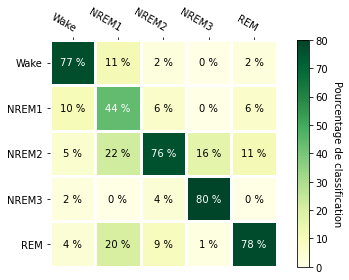

In [13]:
y_estimate =np.argmax( model.predict([x_validation_eeg,x_validation_mvt, meta_validation]), axis=1)
plot_heatmap(y_validation, y_estimate)

In [14]:

def extract_testset(input_signals_list,   mean_mvt , var_mvt,mean_eeg, var_eeg, spoc ):
    with h5py.File(file_xtest, "r") as fi:
        if len(input_signals_list) == 1:
            x_data = fi[input_signals_list[0]][()]
        else:
            x_data = np.zeros([24980,1500,len(input_signals_list)])        
            for i in range(0, len(input_signals_list)):
                if 'x' in input_signals_list[i] or 'y' in input_signals_list[i] or 'z' in input_signals_list[i]:
                    f1 = interp1d(np.arange(0, 300), fi[input_signals_list[i]][()], axis=1)
                    xnew = np.linspace(0, 30, num=1500)
                    x_data[0:24980, 0:1500, i] = f1(xnew)
                else:
                    x_data[0:24980, 0:1500, i] = fi[input_signals_list[i]][()]
        
        metadata =  fi["index_window"][()]
    
            
        mask_eeg = [0,1,2,3,4,5,6]
        print(x_data.shape)

        data_spock = x_data[:,:, mask_eeg]
        data_spock = np.moveaxis(data_spock,1,-1)
        data_spock = spoc.transform(data_spock)
        data_spock = np.moveaxis(data_spock,1,-1)

        
        x_data_eeg,_,_ = stft_preprocessing(data_spock,mean_eeg, var_eeg)
        
        x_data_mvt,_ ,_ = coordinate_preprocessing(x_data[:,:,[7,8,9]], None, None)
            
        x_data_mvt = np.squeeze(x_data_mvt)
        
        x_meta = positional_embeding(metadata)
        
        
        
        return x_data_eeg,x_data_mvt, x_meta 
        
def save_submission(x_test) :
    results_classification= np.argmax( model.predict(x_test), axis=1)
    
    index = np.arange(24688,24688+24980)
    result = np.stack((index, results_classification), axis=-1)
    data = pd.DataFrame(results_classification,index, ['sleep_stage'])
    data.to_csv('./sampleSubmission.csv')
    
    #np.savetxt('./sampleSubmission.csv' , result , delimiter=",")
    
    return True
input_signals_list = np.array(['eeg_1','eeg_2','eeg_3','eeg_4','eeg_5', 'eeg_6', 'eeg_7',"x", "y","z"])

x_test = extract_testset(input_signals_list, mean_mvt , var_mvt,mean_eeg, var_eeg, spoc )
save_submission(x_test)

(24980, 1500, 10)


True

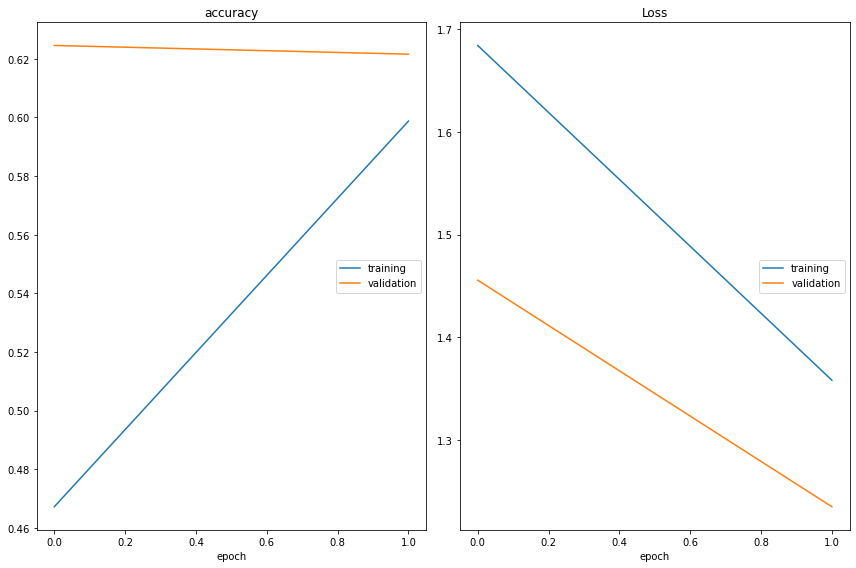

accuracy
	training         	 (min:    0.467, max:    0.599, cur:    0.599)
	validation       	 (min:    0.622, max:    0.625, cur:    0.622)
Loss
	training         	 (min:    1.358, max:    1.684, cur:    1.358)
	validation       	 (min:    1.235, max:    1.456, cur:    1.235)
Epoch 3/35


KeyboardInterrupt: 

In [15]:
from keras import Input ,Model
from keras.layers import Conv2D,MaxPooling2D,Conv1D,Dense , Dropout, Flatten
from tensorflow.keras.layers import concatenate



# define two sets of inputs
inputA = Input(shape=(129,13,4))
inputB = Input(shape=(1499,3))
# the first branch operates on the first input

x = Conv2D(64, (7,7), strides =2 , padding='same', activation=tf.nn.relu,  input_shape=(129,13,4))(inputA)
x = Dropout(0.2)(x)
x =  Conv2D(64, (7,7), strides =2 , padding='same', activation=tf.nn.relu,  input_shape=(129,13,4))(x)
x = MaxPooling2D((2,2), strides=2, data_format='channels_first')(x)
x = Conv2D(32, 5,padding='same', activation=tf.nn.relu)(x)
x = Conv2D(32, 5,padding='same', activation=tf.nn.relu)(x)
x = Conv2D(16, 5,padding='same', activation=tf.nn.relu)(x)
x = Conv2D(8, 5,padding='same', activation=tf.nn.relu)(x)
x = Dropout(0.1)(x)

x = Conv2D(8, 5,padding='same', activation=tf.nn.relu)(x)
x = Flatten()(x)

x= Dense(200, activation=tf.nn.leaky_relu)(x)
x= Dense(100, activation=tf.nn.leaky_relu)(x)
x= Dense(5, activation="linear")(x)

x = Model(inputs=inputA, outputs=x)
#x.summary()
# the second branch opreates on the second input
y = Conv1D(3,10, strides=10,activation=tf.nn.leaky_relu)(inputB)
y = Conv1D(2,5, strides =5, activation=tf.nn.leaky_relu)(y)
y = Dropout(0.1)(y)
y = Conv1D(1,2 ,strides=2 ,activation=tf.nn.leaky_relu)(y)
y = Dropout(0.1)(y)
y = Flatten()(y)

y = Dense(100, activation=tf.nn.leaky_relu)(y)
y= Dense(50, activation=tf.nn.leaky_relu)(y)
y= Dense(5, activation=tf.nn.leaky_relu)(y)

y = Model(inputs=inputB, outputs=y)
#y.summary()
# combine the output of the two branches
combined = concatenate([x.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs

z = Dense(150, activation=tf.nn.leaky_relu)(combined)
z= Dropout(0.1)(z)
z = Dense(100, activation=tf.nn.leaky_relu)(z)
z = Dense(5, activation="softmax")(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

#model.summary()


model.compile(optimizer='adam', 
              loss=custom_loss,
              metrics=['accuracy'])


model.summary()

model.fit([x_train_eeg,x_train_mvt], y_train,
          epochs=35,
          validation_data=([x_validation_eeg, x_validation_mvt], y_validation),
          callbacks=[PlotLossesKeras()],
          verbose='verbose')
make_beep()






In [ ]:
y_estimate =np.argmax( model.predict([x_validation_eeg,x_validation_mvt]), axis=1)
plot_heatmap(y_validation, y_estimate)
y_estimate =np.argmax( model.predict([x_train_eeg,x_train_mvt]), axis=1)
plot_heatmap(y_train, y_estimate)



In [ ]:

def extract_testset(input_signals_list,   mean_mvt , var_mvt,mean_eeg, var_eeg, spoc ):
    with h5py.File(file_xtest, "r") as fi:
        if len(input_signals_list) == 1:
            x_data = fi[input_signals_list[0]][()]
        else:
            x_data = np.zeros([24980,1500,len(input_signals_list)])        
            for i in range(0, len(input_signals_list)):
                if 'x' in input_signals_list[i] or 'y' in input_signals_list[i] or 'z' in input_signals_list[i]:
                    f1 = interp1d(np.arange(0, 300), fi[input_signals_list[i]][()], axis=1)
                    xnew = np.linspace(0, 30, num=1500)
                    x_data[0:24980, 0:1500, i] = f1(xnew)
                else:
                    x_data[0:24980, 0:1500, i] = fi[input_signals_list[i]][()]
            
        mask_eeg = [0,1,2,3,4,5,6]
        print(x_data.shape)

        data_spock = x_data[:,:, mask_eeg]
        data_spock = np.moveaxis(data_spock,1,-1)
        data_spock = spoc.transform(data_spock)
        data_spock = np.moveaxis(data_spock,1,-1)

        
        x_data_eeg,_,_ = stft_preprocessing(data_spock,mean_eeg, var_eeg)
        
        x_data_mvt,_ ,_ = coordinate_preprocessing(x_data[:,:,[7,8,9]], None, None)
            
        x_data_mvt = np.squeeze(x_data_mvt)
        
        return x_data_eeg,x_data_mvt
        
def save_submission(x_test) :
    results_classification= np.argmax( model.predict(x_test), axis=1)
    
    index = np.arange(24688,24688+24980)
    result = np.stack((index, results_classification), axis=-1)
    data = pd.DataFrame(results_classification,index, ['sleep_stage'])
    data.to_csv('./sampleSubmission.csv')
    
    #np.savetxt('./sampleSubmission.csv' , result , delimiter=",")
    
    return True
input_signals_list = np.array(['eeg_1','eeg_2','eeg_3','eeg_4','eeg_5', 'eeg_6', 'eeg_7',"x", "y","z"])

x_test = extract_testset(input_signals_list, mean_mvt , var_mvt,mean_eeg, var_eeg, spoc )
save_submission(x_test)

In [ ]:
 print(prop)

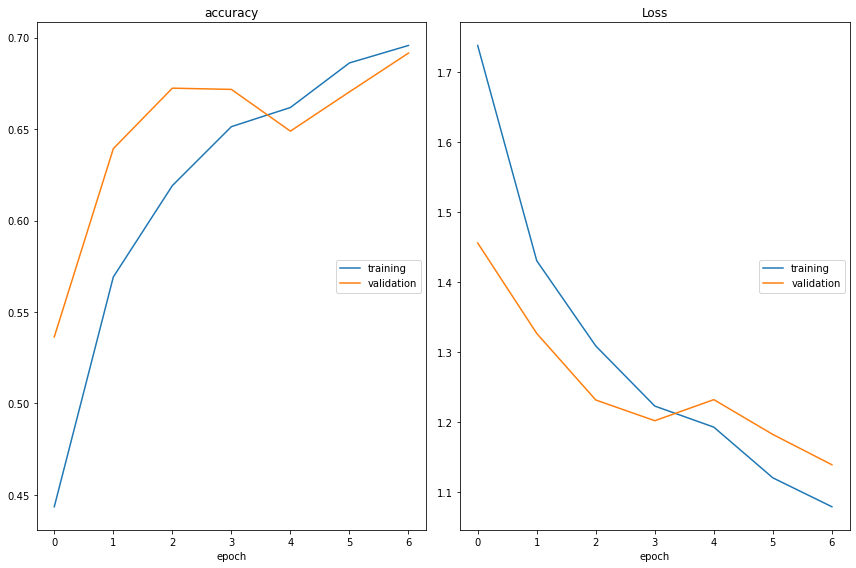

accuracy
	training         	 (min:    0.444, max:    0.696, cur:    0.696)
	validation       	 (min:    0.536, max:    0.692, cur:    0.692)
Loss
	training         	 (min:    1.079, max:    1.738, cur:    1.079)
	validation       	 (min:    1.139, max:    1.455, cur:    1.139)
Epoch 8/15


In [ ]:

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(256, (7,7), strides =2 , padding='same', activation=tf.nn.relu,  input_shape=(129,13,4)),
    tf.keras.layers.Conv2D(256, (7,7), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2,2), strides=2, data_format='channels_first'),

    tf.keras.layers.Conv2D(128, 5,padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(128, 5, padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, 5, padding='same', activation=tf.nn.relu),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(100, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dense(100, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dense(5, activation="softmax")
])



model.compile(optimizer='adam', 
              loss=custom_loss,
              metrics=['accuracy'])


model.summary()

model.fit(x_train_eeg, y_train,
          epochs=15,

          validation_data=(x_validation_eeg, y_validation),
          callbacks=[PlotLossesKeras()],
          verbose='verbose')
make_beep()



In [ ]:


def _adjust_labels(labels, predictions):
  """Adjust the 'labels' tensor by squeezing it if needed."""
  labels = tf.cast(labels, tf.int)
  if len(predictions.shape) == len(labels.shape):
    labels = tf.squeeze(labels, [-1])
  return labels, predictions


def _validate_rank(labels, predictions, weights):
    
  print("po")
  if weights is not None and len(weights.shape) != len(labels.shape):

    print("la")
    raise RuntimeError(
        ("Weight and label tensors were not of the same rank. weights.shape "
         "was %s, and labels.shape was %s.") %
        (predictions.shape, labels.shape))
  if (len(predictions.shape) - 1) != len(labels.shape):
    print("lala")
    raise RuntimeError(
        ("Weighted sparse categorical crossentropy expects `labels` to have a "
         "rank of one less than `predictions`. labels.shape was %s, and "
         "predictions.shape was %s.") % (labels.shape, predictions.shape))


def custom_loss(labels, predictions, weights= None, from_logits=False):
  """Calculate a per-batch sparse categorical crossentropy loss.
  This loss function assumes that the predictions are post-softmax.
  Args:
    labels: The labels to evaluate against. Should be a set of integer indices
      ranging from 0 to (vocab_size-1).
    predictions: The network predictions. Should have softmax already applied.
    weights: An optional weight array of the same shape as the 'labels' array.
      If None, all examples will be used.
    from_logits: Whether the input predictions are logits.
  Returns:
    A loss scalar.
  Raises:
    RuntimeError if the passed tensors do not have the same rank.
  """
  # When using these functions with the Keras core API, we will need to squeeze
  # the labels tensor - Keras adds a spurious inner dimension.

  weights = np.array([0.85763382, 0.93284162, 0.61889411, 0.78903712, 0.80159333])
  print(weights)  

  labels, predictions = _adjust_labels(labels, predictions)
  _validate_rank(labels, predictions, weights)

  example_losses = tf.keras.losses.sparse_categorical_crossentropy(
      labels, predictions, from_logits=from_logits)
  print(example_losses.shape)

  if weights is None:
    return tf.reduce_mean(example_losses)
  weights = tf.cast(weights, predictions.dtype)
  return tf.math.divide_no_nan(
      tf.reduce_sum(example_losses * weights), tf.reduce_sum(weights))


In [ ]:
occurence = np.zeros((5))
for i in range(5):
    occurence[i]= np.sum(np.where(y_train == i))
print(occurence)
plt.bar([1,2,3,4,5] , occurence )

weight =occurence/sum(occurence)
print(1- weight)

In [ ]:
weight = - np.log( occurence/sum(occurence))
weight

In [ ]:
print(tf.reduce_sum(weight))

![](http://)

In [ ]:
ytrue= [1,0,2,3,4,2,1,1]
ytrue = tf.constant(ytrue)
weight =tf.constant([[3, 3, 0.01, 0.001, 0.001]])
 
y_hot = tf.one_hot(ytrue, 5)

print(y_hot)

new_weight = tf.matmul(weight,y_hot, transpose_b=True)
    
    


 

In [ ]:
new_weight

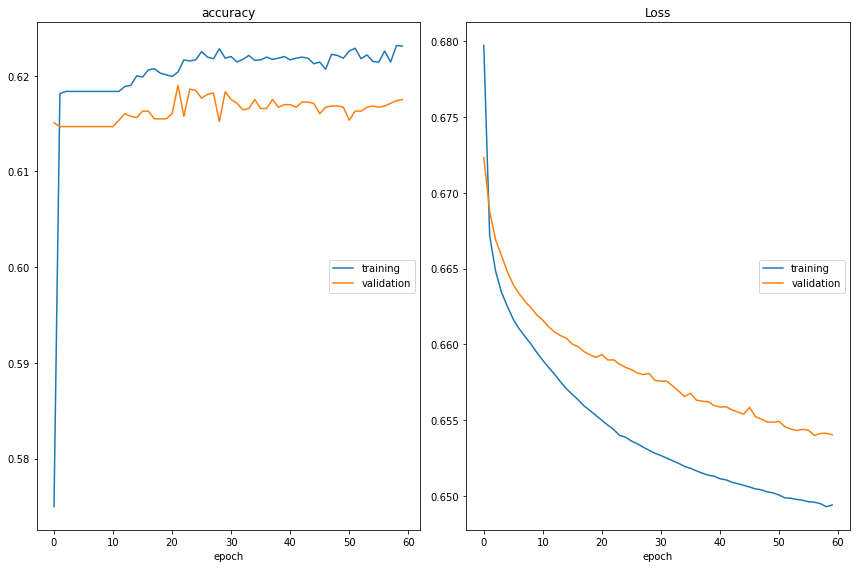

accuracy
	training         	 (min:    0.575, max:    0.623, cur:    0.623)
	validation       	 (min:    0.615, max:    0.619, cur:    0.618)
Loss
	training         	 (min:    0.649, max:    0.680, cur:    0.649)
	validation       	 (min:    0.654, max:    0.672, cur:    0.654)


True

In [39]:


inputC = Input(shape=(6))

k = Dense(6, activation=tf.nn.leaky_relu)(inputC)
k = Dense(6, activation=tf.nn.leaky_relu)(k)
k = Dense(1, activation="sigmoid")(k)
model = Model(inputs=inputC, outputs=k)


# combine the output of the two branches
#combined =concatenate(
# apply a FC layer and then a regression prediction on the
# combined outputs


# our model will accept the inputs of the two branches and
# then output a single value

#model.summary()


model.compile(optimizer='SGD', 
              loss='BinaryCrossentropy',
              metrics=['accuracy'])


model.summary()

model.fit([ meta_train], y_binary_train,
          epochs=60,
          validation_data=([ meta_validation], y_binary_validation),
          callbacks=[PlotLossesKeras()],
          verbose='verbose')
make_beep()


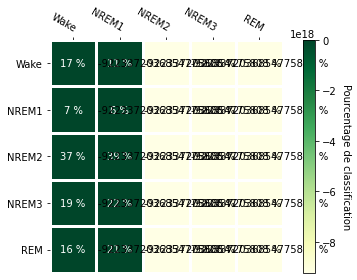

In [31]:
y_estimate =np.argmax( model.predict([meta_validation]), axis=1)
plot_heatmap(y_validation, y_estimate)

In [38]:
y_binary_train = np.where(np.logical_and(y_train == 0, y_train ==1) , 0, 1 )
y_binary_validation = np.where(np.logical_and(y_train == 0, y_train ==1), 0, 1 )


In [25]:
y_binary_train


array([1, 1, 0, ..., 1, 1, 1])

In [32]:
print(y_estimate)

[0 1 1 ... 1 0 0]
